Scalable Agentic AI Video Classification with LoRA Fine-Tuning, LangGraph-Based and NLP Video Summarization
SECTION 1: INSTALLATION AND SETUP

In [23]:
# Install required packages
!pip install -q langgraph typing_extensions torch torchvision peft
!pip install -q moviepy SpeechRecognition pydub
!apt-get install -y ffmpeg
!pip install pygooglenews

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [24]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip, concatenate_videoclips
import speech_recognition as sr
from pydub import AudioSegment
from skimage.metrics import structural_similarity as ssim
from IPython.display import Video, display
from google.colab import drive

# LangGraph Imports
from typing import TypedDict
from langgraph.graph import StateGraph, END

In [25]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
zip_file_path_in_drive = '/content/drive/My Drive/aai-521/videos-ds.zip'
destination_folder = '/content/drive/My Drive/aai-521/videos-ds'
train_data_dir = os.path.join(destination_folder, 'train/')
test_data_dir = os.path.join(destination_folder, 'test/')
train_csv_path = os.path.join(destination_folder, 'train.csv')
test_csv_path = os.path.join(destination_folder, 'test.csv')

# Create destination folder if needed
os.makedirs(destination_folder, exist_ok=True)

# Copy and unzip data
if os.path.exists(zip_file_path_in_drive):
    !cp "{zip_file_path_in_drive}" "{destination_folder}/videos-ds.zip"
    print(" videos-ds.zip loaded from Google Drive")

    zip_file_path = os.path.join(destination_folder, "videos-ds.zip")
    !unzip -o -q "{zip_file_path}" -d "{destination_folder}"
    print(" Data extracted successfully")

    # Verify files
    avi_files = glob.glob(os.path.join(destination_folder, '**', '*.avi'), recursive=True)
    print(f" Found {len(avi_files)} video files")
else:
    print("Error: videos-ds.zip not found")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 videos-ds.zip loaded from Google Drive
 Data extracted successfully
 Found 818 video files


In [26]:
def extract_frames(video_path, num_frames=16):
    """Extract evenly-spaced frames from video, padding if necessary."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return [None] * num_frames # Return list of None if video cannot be opened

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return [None] * num_frames # Return list of None if video has no frames

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    extracted_count = 0
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            extracted_count += 1
        else:
            frames.append(None) # Append None if frame extraction fails

    cap.release()

    # Pad with None if fewer than num_frames were extracted
    while len(frames) < num_frames:
        frames.append(None)

    return frames


def collate_fn(batch):
    """Custom collate function to filter None values and ensure consistent frame count."""
    # Filter out None items from the batch (returned by __getitem__ for videos with no valid frames)
    batch = [item for item in batch if item is not None]

    if not batch:
        return None, None

    inputs, labels_or_paths = zip(*batch)

    # inputs is now a tuple of tensors (Batch x Frames x Channels x Height x Width)
    # Stack the tensors along the batch dimension
    return torch.stack(inputs), list(labels_or_paths)

In [27]:
class VideoDataset(Dataset):
    """Custom dataset for video classification."""

    def __init__(self, data_dir, csv_path, num_frames=16, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.videos = []
        self.labels = []
        self.is_test = is_test
        self.video_paths = []
        self.num_frames = num_frames # Store num_frames

        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            video_name = row['video_name']
            if not self.is_test:
                self.labels.append(row['tag'])

            video_path = os.path.join(data_dir, video_name)
            if os.path.exists(video_path):
                self.videos.append(video_path)
                if self.is_test:
                    self.video_paths.append(video_path)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        frames = extract_frames(video_path, self.num_frames) # Pass num_frames

        if not frames or all(f is None for f in frames):
            return None # Return None if no frames could be extracted

        processed_frames = []
        for frame in frames:
            if frame is not None:
                # Convert frame (numpy array) to tensor and apply transform
                frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float() # HxWx3 to 3xHxW
                if self.transform:
                    processed_frames.append(self.transform(frame_tensor)) # Apply transform
                else:
                    processed_frames.append(frame_tensor)
            else:
                 # Append a tensor of zeros for None frames
                 # Assuming frames are 3 channels, H=112, W=112 after transform
                 processed_frames.append(torch.zeros(3, 112, 112))


        # Stack the processed frames for the current video
        stacked_frames = torch.stack(processed_frames)

        if not self.is_test:
            return stacked_frames, self.labels[idx]
        else:
            return stacked_frames, video_path

In [28]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = VideoDataset(train_data_dir, train_csv_path, transform=transform, is_test=False)
test_dataset = VideoDataset(test_data_dir, test_csv_path, transform=transform, is_test=True)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(set(train_dataset.labels))}")

Training samples: 594
Test samples: 224
Number of classes: 5


In [29]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# Load pre-trained ResNet-18
num_classes = len(set(train_dataset.labels))
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Apply LoRA
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "conv1", "layer1.0.conv1", "layer1.0.conv2", "layer1.1.conv1", "layer1.1.conv2",
        "layer2.0.conv1", "layer2.0.conv2", "layer2.0.downsample.0", "layer2.1.conv1", "layer2.1.conv2",
        "layer3.0.conv1", "layer3.0.conv2", "layer3.0.downsample.0", "layer3.1.conv1", "layer3.1.conv2",
        "layer4.0.conv1", "layer4.0.conv2", "layer4.0.downsample.0", "layer4.1.conv1", "layer4.1.conv2",
        "fc"
    ],
    lora_dropout=0.05,
    bias="none"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(" Model configured with LoRA")

  warnings.warn(

  warnings.warn(msg)



 Using device: cuda
trainable params: 583,040 || all params: 11,762,117 || trainable%: 4.9569
 Model configured with LoRA


In [30]:
num_epochs = 1
model.train()
train_losses = [] # List to store training losses
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        if data is None or data[0] is None:
            continue

        inputs, labels = data
        unique_labels = sorted(list(set(train_dataset.labels)))
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        labels = torch.tensor([label_to_int[l] for l in labels], dtype=torch.long).to(device)
        inputs = inputs.to(device)

        optimizer.zero_grad()
        # Treat all frames in the batch as individual images for the 2D CNN (ResNet)
        outputs = model(inputs.view(-1, 3, 112, 112))
        # Average the frame-level predictions to get a video-level prediction
        outputs = outputs.view(inputs.size(0), inputs.size(1), -1).mean(dim=1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {running_loss/10:.4f}')
            train_losses.append(running_loss/10) # Record the average loss
            running_loss = 0.0

Epoch [1/1], Step [10], Loss: 1.2948
Epoch [1/1], Step [20], Loss: 0.3597
Epoch [1/1], Step [30], Loss: 0.1651


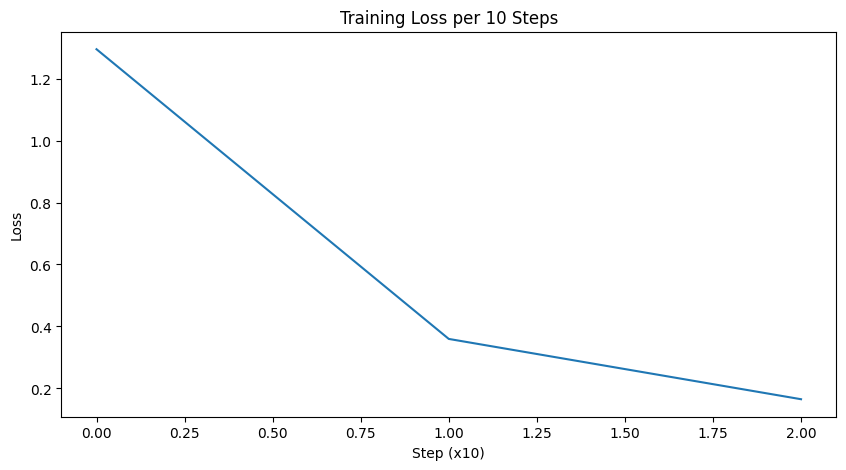

In [31]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss per 10 Steps')
plt.xlabel('Step (x10)')
plt.ylabel('Loss')
plt.show()

In [32]:
!pip install pygooglenews

In [33]:
print("\n" + "="*80)
print("VIDEO CLASSIFICATION EVALUATION")
print("="*80)

model.eval()
predictions = []
video_paths = []

with torch.no_grad():
    for data in test_dataloader:
        if data is None or data[0] is None:
            continue

        inputs, paths = data
        # Use torch.stack to ensure consistent tensor structure if collate_fn returned a list of tensors
        # inputs = torch.stack(inputs).to(device) # Removed redundant stack
        inputs = inputs.to(device)

        outputs = model(inputs.view(-1, 3, 112, 112))
        outputs = outputs.view(inputs.size(0), inputs.size(1), -1).mean(dim=1)

        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        video_paths.extend(paths)

# Map predictions to labels
unique_labels = sorted(list(set(train_dataset.labels)))
label_map = {i: label for i, label in enumerate(unique_labels)}
predicted_labels = [label_map[pred] for pred in predictions]

results_df = pd.DataFrame({
    'video_path': video_paths,
    'predicted_label': predicted_labels
})

print("\n Predictions on test videos:")
print(results_df.head(10))


VIDEO CLASSIFICATION EVALUATION

 Predictions on test videos:
                                          video_path predicted_label
0  /content/drive/My Drive/aai-521/videos-ds/test...     TennisSwing
1  /content/drive/My Drive/aai-521/videos-ds/test...     TennisSwing
2  /content/drive/My Drive/aai-521/videos-ds/test...     TennisSwing
3  /content/drive/My Drive/aai-521/videos-ds/test...     TennisSwing
4  /content/drive/My Drive/aai-521/videos-ds/test...     CricketShot
5  /content/drive/My Drive/aai-521/videos-ds/test...     TennisSwing
6  /content/drive/My Drive/aai-521/videos-ds/test...     TennisSwing
7  /content/drive/My Drive/aai-521/videos-ds/test...     CricketShot
8  /content/drive/My Drive/aai-521/videos-ds/test...     CricketShot
9  /content/drive/My Drive/aai-521/videos-ds/test...     CricketShot



MODEL PERFORMANCE METRICS ON TEST SET
Accuracy: 0.7098
Precision (weighted): 0.7622
Recall (weighted): 0.7098
F1-score (weighted): 0.6988


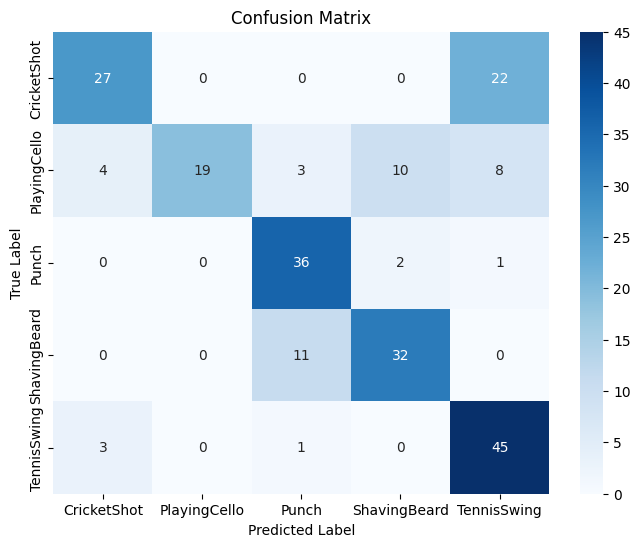

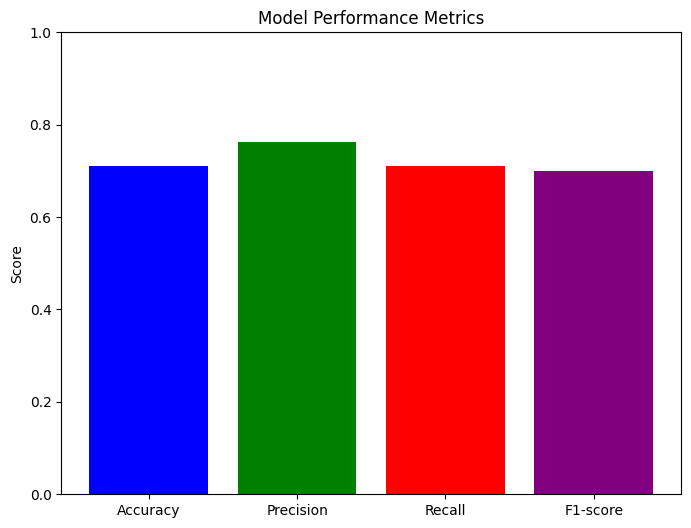

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas

# Prepare data for evaluation (Step 1 of the plan)
# Re-load the test CSV to ensure we have access to original labels
# This assumes test_csv_path is still available from previous cells
try:
    test_df_original = pd.read_csv(test_csv_path)
except NameError:
    print("Error: test_csv_path is not defined. Please ensure the data loading cells have been run.")
    # Exit or handle the error appropriately if test_csv_path is not available
    exit() # Exiting for now, in a real scenario you might raise an error or return

# Create a dictionary mapping video names to true labels from the original test CSV
original_true_label_map = {row['video_name']: row['tag'] for index, row in test_df_original.iterrows()}

# Get true labels corresponding to the video paths in results_df
true_labels = []
predicted_labels = results_df['predicted_label'].tolist()
processed_video_paths = results_df['video_path'].tolist()

# Extract video names from processed_video_paths
processed_video_names = [path.split('/')[-1] for path in processed_video_paths]


# Ensure true labels are retrieved only for the videos that were processed and are in results_df
# by looking up the video name in the original true label map
retrieved_true_labels = []
processed_predicted_labels = [] # Keep track of predicted labels for videos with found true labels

for video_name, predicted_label in zip(processed_video_names, predicted_labels):
    if video_name in original_true_label_map:
        retrieved_true_labels.append(original_true_label_map[video_name])
        processed_predicted_labels.append(predicted_label)
    else:
        # This case indicates a video in results_df was not found in the original test CSV
        print(f"Warning: True label not found in original CSV for video name: {video_name}. Skipping this video for metrics calculation.")


# Use the retrieved true labels and corresponding predicted labels for metrics calculation
true_labels = retrieved_true_labels
predicted_labels = processed_predicted_labels


# Ensure the lists of true and predicted labels have the same length
# This is crucial for metric calculation
if len(true_labels) != len(predicted_labels):
    print(f"Error: Mismatch between number of true labels ({len(true_labels)}) and predicted labels ({len(predicted_labels)}). Cannot calculate metrics.")
elif len(true_labels) == 0:
     print("No matching true labels found for processed videos. Cannot calculate metrics.")
else:
    # Map labels to integers for metrics calculation
    # Use labels from the combined true and predicted labels for a comprehensive mapping
    all_labels = sorted(list(set(true_labels + predicted_labels)))
    label_to_int = {label: idx for idx, label in enumerate(all_labels)}
    int_to_label = {idx: label for label, idx in label_to_int.items()}

    true_labels_int = [label_to_int[label] for label in true_labels]
    predicted_labels_int = [label_to_int[label] for label in predicted_labels]

    # Calculate performance metrics (Step 2 of the plan)
    accuracy = accuracy_score(true_labels_int, predicted_labels_int)
    precision = precision_score(true_labels_int, predicted_labels_int, average='weighted')
    recall = recall_score(true_labels_int, predicted_labels_int, average='weighted')
    f1 = f1_score(true_labels_int, predicted_labels_int, average='weighted')

    print("\n" + "="*80)
    print("MODEL PERFORMANCE METRICS ON TEST SET")
    print("="*80)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")
    print("="*80)

    # Generate confusion matrix (Step 3 of the plan)
    conf_matrix = confusion_matrix(true_labels_int, predicted_labels_int)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels) # Use all_labels for consistent tick labels
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Visualize performance metrics (Step 4 of the plan)
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    metrics_values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple'])
    plt.ylim(0, 1) # Metrics are between 0 and 1
    plt.ylabel('Score')
    plt.title('Model Performance Metrics')
    plt.show()

In [35]:
import nltk

# Download necessary NLTK data
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

print("NLTK data downloaded successfully.")

NLTK data downloaded successfully.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [36]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from langgraph.graph import StateGraph, END

In [37]:
!pip install -q ultralytics

In [38]:
from ultralytics import YOLO

try:
    # Load a pre-trained YOLOv8n model
    yolo_model = YOLO('yolov8n.pt')
    print("YOLOv8 model loaded successfully without falling back to a dummy model.")
except Exception as e:
    print(f"Error loading YOLOv8 model: {e}")
    print("YOLOv8 model could not be loaded. Please check the ultralytics installation and model weights.")

YOLOv8 model loaded successfully without falling back to a dummy model.


In [39]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
zip_file_path_in_drive = '/content/drive/My Drive/aai-521/videos-ds.zip'
destination_folder = '/content/drive/My Drive/aai-521/videos-ds'
train_data_dir = os.path.join(destination_folder, 'train/')
test_data_dir = os.path.join(destination_folder, 'test/')
train_csv_path = os.path.join(destination_folder, 'train.csv')
test_csv_path = os.path.join(destination_folder, 'test.csv')

# Create destination folder if needed
os.makedirs(destination_folder, exist_ok=True)

# Copy and unzip data
if os.path.exists(zip_file_path_in_drive):
    !cp "{zip_file_path_in_drive}" "{destination_folder}/videos-ds.zip"
    print(" videos-ds.zip loaded from Google Drive")

    zip_file_path = os.path.join(destination_folder, "videos-ds.zip")
    !unzip -o -q "{zip_file_path}" -d "{destination_folder}"
    print(" Data extracted successfully")

    # Verify files
    avi_files = glob.glob(os.path.join(destination_folder, '**', '*.avi'), recursive=True)
    print(f" Found {len(avi_files)} video files")
else:
    print("Error: videos-ds.zip not found")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 videos-ds.zip loaded from Google Drive
 Data extracted successfully
 Found 818 video files


Sample video chosen: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c05.avi
Processing video: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c05.avi
Finished processing. Total frames processed: 95
Total number of extracted keyframes: 9
Displaying the first extracted keyframe:


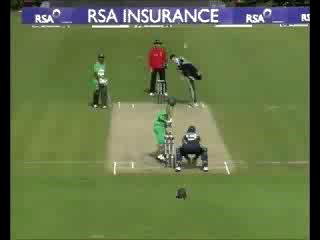

In [40]:
import torch

def summarize_video_yolo(video_path, yolo_model, desired_classes, detection_count_threshold, movement_threshold, scene_change_threshold):
    """
    Summarizes a video by extracting keyframes based on YOLO object detection,
    detection count prioritization, movement, and scene change.

    Args:
        video_path (str): Path to the input video file.
        yolo_model: The pre-loaded YOLO model object (e.g., YOLOv8n from ultralytics).
        desired_classes (list): List of class names to prioritize (e.g., ['person', 'car']).
        detection_count_threshold (int): Minimum number of desired objects to consider a frame for keyframe status.
        movement_threshold (float): SSIM threshold for detecting significant movement (lower value means more movement).
        scene_change_threshold (float): SSIM threshold for detecting a scene change (lower value means more change).

    Returns:
        list: A list of keyframes (numpy arrays).
    """
    print(f"Processing video: {video_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return []

    keyframes = []
    prev_frame_gray = None
    prev_keyframe_gray = None
    frame_count = 0

    # Get class names from the model
    class_names = yolo_model.names
    # Map class_names values to a list for easier lookup
    yolo_class_labels = list(class_names.values())

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 1. YOLO Object Detection and Prioritization
        results = yolo_model(frame_rgb, verbose=False) # Run YOLOv8 inference
        detections_in_frame = 0

        # Process results
        for r in results:
            for c in r.boxes.cls:
                class_id = int(c)
                # Use yolo_class_labels list for lookup
                if class_id < len(yolo_class_labels) and yolo_class_labels[class_id] in desired_classes:
                    detections_in_frame += 1

        consider_for_keyframe = False
        if detections_in_frame >= detection_count_threshold:
            consider_for_keyframe = True

        # 2. Movement Detection (using SSIM - (Structural Similarity Index Measure))
        movement_detected = False
        if prev_frame_gray is not None:
            score, _ = ssim(prev_frame_gray, frame_gray, full=True)
            if score < movement_threshold: # Lower SSIM means more difference/movement
                movement_detected = True
        prev_frame_gray = frame_gray.copy()

        # 3. Scene Change Detection (using SSIM with previous keyframe or first frame)
        scene_change_detected = False
        if not keyframes: # First frame is always a keyframe and reference for scene change
            scene_change_detected = True
            prev_keyframe_gray = frame_gray.copy()
        elif prev_keyframe_gray is not None: # Compare with the last stored keyframe
            score, _ = ssim(prev_keyframe_gray, frame_gray, full=True)
            if score < scene_change_threshold: # Lower SSIM means more difference/scene change
                scene_change_detected = True

        # Keyframe selection logic
        if consider_for_keyframe and (movement_detected or scene_change_detected):
            keyframes.append(frame_rgb)
            prev_keyframe_gray = frame_gray.copy() # Update reference for scene change
        elif consider_for_keyframe and not keyframes: # Always add the first frame if it meets criteria
            keyframes.append(frame_rgb)
            prev_keyframe_gray = frame_gray.copy()
        elif movement_detected and not keyframes: # Always add first frame if movement is detected (and no keyframes yet)
            keyframes.append(frame_rgb)
            prev_keyframe_gray = frame_gray.copy()
        elif scene_change_detected and not keyframes: # Always add first frame if scene change is detected (and no keyframes yet)
            keyframes.append(frame_rgb)
            prev_keyframe_gray = frame_gray.copy()

        # If no keyframes yet and it's the first frame, add it as a baseline
        if not keyframes and frame_count == 1:
            keyframes.append(frame_rgb)
            prev_keyframe_gray = frame_gray.copy()

    cap.release()
    print(f"Finished processing. Total frames processed: {frame_count}")
    return keyframes

# Choose a sample video file from the extracted dataset
# Using the first avi file found in the previous step
sample_video_file = avi_files[0]
sample_video_file = avi_files[4]

print(f"Sample video chosen: {sample_video_file}")

# Call the summarize_video_yolo function with the pre-loaded yolo_model
desired_classes = ['person', 'car', 'bicycle','shaving','punch']  # Example classes
detection_count_threshold = 1 # At least 1 desired object detected
movement_threshold = 0.95   # SSIM score below this means significant movement (0.95-1.0 is very similar)
screen_change_threshold = 0.85 # SSIM score below this means a screen change (0.85-1.0 is very similar)

extracted_keyframes = summarize_video_yolo(
    sample_video_file,
    yolo_model, # Pass the pre-loaded YOLOv8 model
    desired_classes,
    detection_count_threshold,
    movement_threshold,
    screen_change_threshold
)

# Print the total number of keyframes extracted
print(f"Total number of extracted keyframes: {len(extracted_keyframes)}")

# Display the first extracted keyframe (if any)
if extracted_keyframes:
    print("Displaying the first extracted keyframe:")
    first_keyframe_pil = Image.fromarray(extracted_keyframes[0])
    display(first_keyframe_pil)
else:
    print("No keyframes were extracted.")

In [42]:














!pip install -q pygooglenews
!pip install -q SpeechRecognition
!pip install -q langgraph typing_extensions

import nltk
# Download necessary NLTK data
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

from typing import TypedDict, List # Import List here
from pygooglenews import GoogleNews
from IPython.display import Video, display
import cv2
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip, concatenate_videoclips, ImageClip # Added ImageClip
import speech_recognition as sr
from pydub import AudioSegment
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
from transformers import pipeline # Import pipeline
import torch # Import torch for device check
import os

# For model initialization and data loading
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from peft import LoraConfig, get_peft_model

# LangGraph Imports (Moved these explicitly here for robustness)
from langgraph.graph import StateGraph, END

# --- Data Loading and Preprocessing Functions/Classes ---

def extract_frames(video_path, num_frames=16):
    """Extract evenly-spaced frames from video, padding if necessary."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return [None] * num_frames # Return list of None if video cannot be opened

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return [None] * num_frames # Return list of None if video has no frames

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    extracted_count = 0
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            extracted_count += 1
        else:
            frames.append(None) # Append None if frame extraction fails

    cap.release()

    # Pad with None if fewer than num_frames were extracted
    while len(frames) < num_frames:
        frames.append(None)

    return frames


def collate_fn(batch):
    """Custom collate function to filter None values and ensure consistent frame count."""
    # Filter out None items from the batch (returned by __getitem__ for videos with no valid frames)
    batch = [item for item in batch if item is not None]

    if not batch:
        return None, None

    inputs, labels_or_paths = zip(*batch)

    # inputs is now a tuple of tensors (Batch x Frames x Channels x Height x Width)
    # Stack the tensors along the batch dimension
    return torch.stack(inputs), list(labels_or_paths)


class VideoDataset(Dataset):
    """Custom dataset for video classification."""

    def __init__(self, data_dir, csv_path, num_frames=16, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.videos = []
        self.labels = []
        self.is_test = is_test
        self.video_paths = []
        self.num_frames = num_frames # Store num_frames

        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            video_name = row['video_name']
            if not self.is_test:
                self.labels.append(row['tag'])

            video_path = os.path.join(data_dir, video_name)
            if os.path.exists(video_path):
                self.videos.append(video_path)
                if self.is_test:
                    self.video_paths.append(video_path)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        frames = extract_frames(video_path, self.num_frames) # Pass num_frames

        if not frames or all(f is None for f in frames):
            return None # Return None if no frames could be extracted

        processed_frames = []
        for frame in frames:
            if frame is not None:
                # Convert frame (numpy array) to tensor and apply transform
                frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float() # HxWx3 to 3xHxW
                if self.transform:
                    processed_frames.append(self.transform(frame_tensor)) # Apply transform
                else:
                    processed_frames.append(frame_tensor)
            else:
                 # Append a tensor of zeros for None frames
                 # Assuming frames are 3 channels, H=112, W=112 after transform
                 processed_frames.append(torch.zeros(3, 112, 112))


        # Stack the processed frames for the current video
        stacked_frames = torch.stack(processed_frames)

        if not self.is_test:
            return stacked_frames, self.labels[idx]
        else:
            return stacked_frames, video_path

# --- Assume an LLM is initialized and available as `llm_model` ---
# Example (replace with your actual LLM initialization):
# from langchain_google_genai import ChatGoogleGenerativeAI
# from google.colab import userdata
# # Retrieve API key from Colab Secrets
# try:
#     GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
#     llm_model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0, google_api_key=GOOGLE_API_KEY)
# except Exception as e:
#     print(f"Error initializing LLM: {e}")
#     print("Please ensure you have stored your Google Cloud API key in Colab Secrets named 'GOOGLE_API_KEY'.")
#     llm_model = None # Set llm_model to None if initialization fails

# Initialize Hugging Face text generation pipeline
try:
    # Using a small, free public model as an example
    llm_model = pipeline(
        "text2text-generation",
        model="google/flan-t5-small", # Using a small Flan-T5 model
        device=0 if torch.cuda.is_available() else -1 # Use GPU if available
    )
    print("Hugging Face text generation pipeline initialized.")
except Exception as e:
    print(f"Error initializing Hugging Face pipeline: {e}")
    llm_model = None


class SummaryState(TypedDict):
    video_path: str
    audio_path: str
    summary_video_path: str
    transcript: str
    duration: float
    summary_clips_count: int
    error: str
    # --- NEW STATE KEY ---
    news: List[dict] # To store fetched news articles (title, link, source, summary)
    predicted_label: str # Add predicted label to the state
    processed_label_words: List[str] # Add key for processed label words


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_label(state: SummaryState) -> SummaryState:
    """Node: Processes the predicted label into lemmatized words and filters irrelevant terms."""
    print("\n 4. Executing Label Lemmatization...")
    predicted_label = state.get('predicted_label')

    if not predicted_label:
        print("--- Node: lemmatize_label ---")
        print("Error: Predicted label not found. Skipping lemmatization.")
        return {**state, "processed_label_words": []}

    print(f"--- Node: lemmatize_label (Original Label: {predicted_label}) ---")

    # Convert CamelCase to separate words
    words = re.findall('[A-Z][a-z]*', predicted_label)
    if not words: # Handle cases like "Punch" which might not be split by CamelCase
        words = [predicted_label]

    lemmatized_words = [lemmatizer.lemmatize(word.lower(), pos=wordnet.VERB) for word in words] # Lemmatize as verbs initially
    lemmatized_words = [lemmatizer.lemmatize(word, pos=wordnet.NOUN) for word in lemmatized_words] # Then lemmatize as nouns

    # Simple filtering: remove common verbs that might not be the primary action
    # This list can be expanded based on the specific labels in your dataset
    irrelevant_verbs = ['shoot', 'play', 'swing']
    filtered_words = [word for word in lemmatized_words if word not in irrelevant_verbs]

    # Further filtering: keep only words that are likely nouns or verbs representing the core concept
    # This is a more advanced approach and might require more sophisticated NLP techniques
    # For now, we'll stick to the simple irrelevant verb filtering

    print(f"✓ Processed Label Words: {filtered_words}")

    return {**state, "processed_label_words": filtered_words}


def extract_audio(state: SummaryState) -> SummaryState:
    """Node 1: Extracts audio from the video and updates the state."""
    print("\n 1. Executing Audio Extraction...")
    video_path = state['video_path']
    audio_path = video_path.replace('.avi', '.wav')

    try:
        video_clip = VideoFileClip(video_path)
        if video_clip.audio: # Check if audio track exists
            video_clip.audio.write_audiofile(audio_path, logger=None)
            print("✓ Audio extracted.")
            audio_extracted = True
        else:
            print("⚠ No audio track found in video. Skipping audio extraction.")
            audio_extracted = False
            audio_path = "" # Reset audio_path if no audio
        video_clip.close()
        return {**state, "audio_path": audio_path, "error": None}
    except Exception as e:
        print(f"✗ Audio extraction failed: {e}")
        return {**state, "error": f"Audio extraction failed: {e}"}


def transcribe_audio(state: SummaryState) -> SummaryState:
    """Node 2: Transcribes the extracted audio and updates the state with the transcript."""
    print(" 2. Executing Transcription...")
    audio_path = state.get('audio_path')

    if not audio_path or state.get('error'):
        # If no audio path or prior error, skip transcription
        print("⚠ Skipping transcription due to no audio or prior error.")
        return {**state, "transcript": "Skipped due to no audio or prior error.", "error": state.get('error')}

    transcript = "No speech detected in video"
    try:
        r = sr.Recognizer()
        with sr.AudioFile(audio_path) as source:
            audio_data = r.record(source)
            transcript = r.recognize_google(audio_data)
        print(f"✓ Transcript generated: {transcript[:50]}...")
        return {**state, "transcript": transcript, "error": None}
    except Exception as e:
        # Catch transcription errors (e.g., no speech detected)
        print(f"⚠ Transcription failed: {e} (assuming no speech or transcription issue)")
        return {**state, "transcript": transcript, "error": None}


def create_summary_video(state: SummaryState) -> SummaryState:
    """Node 3: Extracts key frames using YOLO and creates the summary video."""
    print(" 3. Executing Summary Video Creation (using YOLO)...")
    video_path = state['video_path']
    summary_video_path = video_path.replace('.avi', '_yolo_summary.mp4') # Change name to reflect YOLO

    try:
        # Access global variables for YOLO summarization parameters
        # These were defined in previous cells and should be available in the global scope
        global yolo_model, desired_classes, detection_count_threshold, movement_threshold, screen_change_threshold

        # Summarize video using YOLO-based keyframe extraction
        extracted_keyframes = summarize_video_yolo(
            video_path,
            yolo_model,
            desired_classes,
            detection_count_threshold,
            movement_threshold,
            screen_change_threshold # Use the global variable here
        )

        if not extracted_keyframes:
            return {**state, "error": "No keyframes extracted by YOLO for summary."}

        # Get original video properties for the new summary video
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()

        if fps == 0:
            return {**state, "error": "Original video FPS is zero, cannot create summary video."}

        # Create video from extracted keyframes using moviepy
        # Need to convert numpy array frames to Image clips for moviepy
        # Each keyframe will be a static image for a short duration
        # Let's make each keyframe last for 1 second in the summary video
        clips = [ImageClip(frame).set_duration(1) for frame in extracted_keyframes]

        # Resize clips to original video dimensions if they are different (YOLO might resize internally)
        # Ensure consistency in size for concatenation
        clips = [clip.resize((width, height)) for clip in clips]

        if clips:
            final_summary = concatenate_videoclips(clips, method="compose") # Use compose method for transitions if needed
            final_summary.write_videofile(summary_video_path, codec='libx264',
                                           audio_codec='aac', logger=None, fps=fps) # Use original FPS
            final_summary.close()

            print(f"✓ YOLO-based summary video saved: {summary_video_path}")

            return {**state,
                    "summary_video_path": summary_video_path,
                    "duration": final_summary.duration, # Actual duration of the summary video
                    "summary_clips_count": len(extracted_keyframes), # Number of keyframes used
                    "error": None
                   }
        else:
            return {**state, "error": "No clips created from keyframes for summary."}

    except Exception as e:
        print(f"✗ YOLO-based summary video creation failed: {e}")
        return {**state, "error": f"YOLO-based summary creation failed: {e}"}


def fetch_news_node(state: SummaryState) -> dict:
    """
    Fetches news from Google News based on the video's classified topic and summarizes articles.
    """
    gn = GoogleNews(lang='en', country='US')

    # 1. Extract the search query (classified topic) - now use processed words
    topic_words = state.get("processed_label_words")

    # 2. Handle cases where the topic is missing
    if not topic_words:
        print("--- Node: fetch_news ---")
        print("Error: Processed label words not found. Skipping news fetch.")
        return {"news": []}

    # Join the words to form a search query
    search_query = " ".join(topic_words)
    print(f"--- Node: fetch_news (Search Query: {search_query}) ---")

    fetched_news_with_summary = []
    try:
        # 3. Search Google News (using pygooglenews wrapper)
        # Search for articles about the topic in the last 7 days ('7d') for freshness
        search_result = gn.search(query=search_query, when='7d')

        # 4. Process and structure the results, and summarize content (Limit to first 10)
        for entry in search_result['entries'][:10]: # Limit to the first 10 entries
            article_title = entry.title
            article_link = entry.link
            article_published = entry.published
            article_source = entry.source.get('title', 'Unknown Source')

            # --- Summarization using LLM ---
            article_summary = "Summary not available." # Default summary
            try:
                # Attempt to get article content (this might require additional libraries or scraping)
                # For this example, we'll just summarize the title and a placeholder if no content
                article_content = f"Title: {article_title}" # Placeholder - ideally fetch full content

                # Ensure llm_model is initialized and available
                if llm_model:
                    print(f" Summarizing: {article_title[:50]}...")
                    # Create a prompt for summarization
                    prompt = f"Summarize the following news article:\n\n{article_content}\n\nSummary:"
                    # Generate summary using the LLM - Use .invoke() for ChatGoogleGenerativeAI
                    # response = llm_model.invoke(prompt) # Modified to use .invoke()
                    # article_summary = response.content.strip() # Access content from the response

                    # Use Hugging Face pipeline for summarization
                    summary_result = llm_model(prompt)
                    article_summary = summary_result[0]['generated_text'].strip()


                else:
                     print("⚠ LLM model not initialized. Skipping summarization.")

            except Exception as e:
                print(f"⚠ Error summarizing article {article_title[:50]}...: {e}")
                article_summary = f"Error summarizing: {e}" # Indicate summarization failed


            fetched_news_with_summary.append({
                "title": article_title,
                "link": article_link,
                "published": article_published,
                "source": article_source,
                "summary": article_summary # Add the summary to the news dictionary
            })

        print(f"Successfully fetched and attempted to summarize {len(fetched_news_with_summary)} news articles.")

        # 5. Return the update to the LangGraph state
        return {"news": fetched_news_with_summary}

    except Exception as e:
        print(f"An error occurred while fetching news: {e}")
        return {"news": []}

def display_news_node(state: SummaryState) -> SummaryState:
    """Node: Displays the top 5 news articles with their summaries."""
    print("\n 5. Executing Display News...")
    news_articles = state.get('news')

    print("\n" + "="*80)
    print("TOP 5 RELATED NEWS ARTICLES")
    print("="*80)

    if news_articles:
        for i, article in enumerate(news_articles[:5]):
            print(f"{i+1}. Title: {article.get('title', 'N/A')}")
            print(f"   Link: {article.get('link', 'N/A')}")
            print(f"   Summary: {article.get('summary', 'N/A')}") # Display the summary
            print("-" * 20)
    else:
        print("No news articles were fetched.")

    print("="*80)

    return state # Return the state unchanged

# --- Paths and Data Loaders Initialization (Moved from previous cells) ---
# Define paths
zip_file_path_in_drive = '/content/drive/My Drive/aai-521/videos-ds.zip'
destination_folder = '/content/drive/My Drive/aai-521/videos-ds'
train_data_dir = os.path.join(destination_folder, 'train/')
test_data_dir = os.path.join(destination_folder, 'test/')
train_csv_path = os.path.join(destination_folder, 'train.csv')
test_csv_path = os.path.join(destination_folder, 'test.csv')

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = VideoDataset(train_data_dir, train_csv_path, transform=transform, is_test=False)
test_dataset = VideoDataset(test_data_dir, test_csv_path, transform=transform, is_test=True)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(set(train_dataset.labels))}")

# --- Model Initialization (Moved from previous cells) ---
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# Load pre-trained ResNet-18
num_classes = len(set(train_dataset.labels))
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Apply LoRA
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "conv1", "layer1.0.conv1", "layer1.0.conv2", "layer1.1.conv1", "layer1.1.conv2",
        "layer2.0.conv1", "layer2.0.conv2", "layer2.0.downsample.0", "layer2.1.conv1", "layer2.1.conv2",
        "layer3.0.conv1", "layer3.0.conv2", "layer3.0.downsample.0", "layer3.1.conv1", "layer3.1.conv2",
        "layer4.0.conv1", "layer4.0.conv2", "layer4.0.downsample.0", "layer4.1.conv1", "layer4.1.conv2",
        "fc"
    ],
    lora_dropout=0.05,
    bias="none"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(" Model configured with LoRA")


# --- 10.2 Build and Run the LangGraph ---

# Build the graph
workflow = StateGraph(SummaryState)

# Add nodes
workflow.add_node("extract_audio", extract_audio)
workflow.add_node("transcribe_audio", transcribe_audio)
workflow.add_node("create_summary_video", create_summary_video)
workflow.add_node("lemmatize_label", lemmatize_label) # Add the new lemmatization node
workflow.add_node("fetch_news_node", fetch_news_node)
workflow.add_node("display_news_node", display_news_node) # Add the display news node

# Set edges
workflow.add_edge('extract_audio', 'transcribe_audio')
workflow.add_edge('transcribe_audio', 'create_summary_video')
workflow.add_edge('create_summary_video', 'lemmatize_label') # Add edge to lemmatization node
workflow.add_edge('lemmatize_label', "fetch_news_node") # Add edge from lemmatization node to fetch_news_node
workflow.add_edge("fetch_news_node", "display_news_node") # Add edge from fetch news to display news
workflow.add_edge("display_news_node", END)

# Set the starting point
workflow.set_entry_point('extract_audio')

# Compile the graph
app = workflow.compile()

# Run the graph on a sample video
print("\n" + "="*80)
print("LANGGRAPH EXECUTION START")
print("="*80)

# --- Code from cell foSgg4np7eM7 to define results_df ---
model.eval()
predictions = []
video_paths = []

with torch.no_grad():
    for data in test_dataloader:
        if data is None or data[0] is None:
            continue

        inputs, paths = data
        inputs = inputs.to(device)

        outputs = model(inputs.view(-1, 3, 112, 112))
        outputs = outputs.view(inputs.size(0), inputs.size(1), -1).mean(dim=1);

        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        video_paths.extend(paths)

unique_labels = sorted(list(set(train_dataset.labels)))
label_map = {i: label for i, label in enumerate(unique_labels)}
predicted_labels = [label_map[pred] for pred in predictions]

results_df = pd.DataFrame({
    'video_path': video_paths,
    'predicted_label': predicted_labels
})
print("\n Predictions on test videos (results_df generated within this cell):")
print(results_df.head(10))
# --- End of code from cell foSgg4np7eM7 ---

sample_video_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c05.avi'

# Get the predicted label for the sample video from results_df
sample_video_row = results_df[results_df['video_path'] == sample_video_path]
if not sample_video_row.empty:
    predicted_label = sample_video_row['predicted_label'].iloc[0]
else:
    predicted_label = "Unknown" # Default if not found

initial_state = {
    'video_path': sample_video_path,
    'audio_path': '',
    'summary_video_path': '',
    'transcript': '',
    'duration': 0.0,
    'summary_clips_count': 0,
    'error': None,
    'predicted_label': predicted_label,
    'processed_label_words': []
}

final_state = app.invoke(initial_state)

# --- 10.3 Display Final Results ---

print("\n" + "="*80)
print("LANGGRAPH FINAL SUMMARY OUTPUT")
print("="*80)

if final_state.get('error'):
    print(f"ERROR: {final_state['error']}")
else:
    print(f"Video Path: {final_state['video_path']}")
    print(f"Predicted Label: {final_state.get('predicted_label', 'N/A')}") # Display original predicted label
    print(f"Processed Label Words: {final_state.get('processed_label_words', 'N/A')}") # Display processed words
    print(f"Transcript: {final_state['transcript']}")
    print(f"Original duration: {final_state['duration']:.2f}s")
    print(f"Summary duration: {final_state['summary_clips_count']}s")
    print(f"News Articles: {len(final_state.get('news', []))}") # Display number of fetched news articles

    try:
        display(Video(final_state['summary_video_path'], embed=True, width=640))
    except:
        print(f"Video saved but cannot display inline: {final_state['summary_video_path']}")

print("\n" + "="*80)
print("PROCESSING COMPLETE")
print("="*80)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Device set to use cuda:0


Hugging Face text generation pipeline initialized.


  warnings.warn(

  warnings.warn(msg)



Training samples: 594
Test samples: 224
Number of classes: 5
 Using device: cuda
trainable params: 583,040 || all params: 11,762,117 || trainable%: 4.9569
 Model configured with LoRA

LANGGRAPH EXECUTION START

 Predictions on test videos (results_df generated within this cell):
                                          video_path predicted_label
0  /content/drive/My Drive/aai-521/videos-ds/test...           Punch
1  /content/drive/My Drive/aai-521/videos-ds/test...           Punch
2  /content/drive/My Drive/aai-521/videos-ds/test...           Punch
3  /content/drive/My Drive/aai-521/videos-ds/test...    PlayingCello
4  /content/drive/My Drive/aai-521/videos-ds/test...    ShavingBeard
5  /content/drive/My Drive/aai-521/videos-ds/test...           Punch
6  /content/drive/My Drive/aai-521/videos-ds/test...           Punch
7  /content/drive/My Drive/aai-521/videos-ds/test...    ShavingBeard
8  /content/drive/My Drive/aai-521/videos-ds/test...    ShavingBeard
9  /content/drive/My Drive/aai


PROCESSING COMPLETE


In [17]:
!pip install langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.9.0 which is incompatible.


In [ ]:
#7 videos

In [49]:
print("Processing multiple videos!!!")

Processing multiple videos!!!


In [51]:
import random

print("\n" + "="*80)
print("PROCESSING A RANDOM SAMPLE OF TEST VIDEOS WITH LANGGRAPH")
print("="*80)

all_test_video_paths = results_df['video_path'].tolist()

# Select a random sample of 7 videos
num_videos_to_process = 2
if len(all_test_video_paths) > num_videos_to_process:
    selected_video_paths = random.sample(all_test_video_paths, num_videos_to_process)
else:
    selected_video_paths = all_test_video_paths

processing_results = []

for video_path in selected_video_paths:
    print(f"\nProcessing video: {video_path}")

    # Get the predicted label for the current video
    video_row = results_df[results_df['video_path'] == video_path]
    if not video_row.empty:
        predicted_label = video_row['predicted_label'].iloc[0]
    else:
        predicted_label = "Unknown" # Default if not found

    initial_state = {
        'video_path': video_path,
        'audio_path': '',
        'summary_video_path': '',
        'transcript': '',
        'duration': 0.0,
        'summary_clips_count': 0,
        'error': None,
        'predicted_label': predicted_label,
        'processed_label_words': []
    }

    try:
        final_state = app.invoke(initial_state)
        processing_results.append(final_state)
        print(f"Finished processing {video_path}")
        try:
            display(Video(final_state['summary_video_path'], embed=True, width=640))
        except:
            print(f"Video saved but cannot display inline: {final_state['summary_video_path']}")
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        processing_results.append({**initial_state, 'error': str(e)})

print("\n" + "="*80)
print(f"PROCESSED {len(processing_results)} TEST VIDEOS")
print("="*80)

# You can now access the results for each video in the processing_results list
# For example, to see the processed label words and news for the first video:
print(processing_results[0].get('processed_label_words'))
print(processing_results[0].get('news'))


PROCESSING A RANDOM SAMPLE OF TEST VIDEOS WITH LANGGRAPH

Processing video: /content/drive/My Drive/aai-521/videos-ds/test/v_ShavingBeard_g05_c06.avi

 1. Executing Audio Extraction...
✓ Audio extracted.
 2. Executing Transcription...
⚠ Transcription failed:  (assuming no speech or transcription issue)
 3. Executing Summary Video Creation (using YOLO)...
Processing video: /content/drive/My Drive/aai-521/videos-ds/test/v_ShavingBeard_g05_c06.avi
Finished processing. Total frames processed: 521
✓ YOLO-based summary video saved: /content/drive/My Drive/aai-521/videos-ds/test/v_ShavingBeard_g05_c06_yolo_summary.mp4

 4. Executing Label Lemmatization...
--- Node: lemmatize_label (Original Label: Punch) ---
✓ Processed Label Words: ['punch']
--- Node: fetch_news (Search Query: punch) ---
 Summarizing: Payne suspended 1 game for St. Brown punch - ESPN...
 Summarizing: Commanders DT Daron Payne suspended 1 game for thr...
 Summarizing: Jeans Pants Trouser Denim White Punch Patch Trendy...
 Su


Processing video: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c05.avi

 1. Executing Audio Extraction...
✓ Audio extracted.
 2. Executing Transcription...
⚠ Transcription failed:  (assuming no speech or transcription issue)
 3. Executing Summary Video Creation (using YOLO)...
Processing video: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c05.avi
Finished processing. Total frames processed: 95
✓ YOLO-based summary video saved: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c05_yolo_summary.mp4

 4. Executing Label Lemmatization...
--- Node: lemmatize_label (Original Label: PlayingCello) ---
✓ Processed Label Words: ['cello']
--- Node: fetch_news (Search Query: cello) ---
 Summarizing: Winners announced at the 2025 Isang Yun Cello Comp...
 Summarizing: Gautier Capuçon plays cello while suspended on a z...
 Summarizing: Poway Symphony Features Cello (Qiele) Guo on His N...
 Summarizing: Butterfly And Cello Print Luggage Cover For


PROCESSED 2 TEST VIDEOS
['punch']
[{'title': 'Payne suspended 1 game for St. Brown punch - ESPN', 'link': 'https://news.google.com/rss/articles/CBMipgFBVV95cUxQcHdpMGFXXzRkVFgzNF9FcDB4bUYxcDB1cjJZNWdodUl6TXFJN09oTkM5b2hqc0dhM1ljUHZLUWRlSEdWVzA4cy1faDY3RlNZUE5FenF3enlmZThUZXJqaTR2MXY1dEh4RzdNRlZRUEo5WmVwZmFPU2VxZ0NQYmpNVk1KeVBpd2NJSG9neFVpSDJneWYtSWVwdjVySGFxSEp0dTktUUhn?oc=5', 'published': 'Mon, 10 Nov 2025 14:30:00 GMT', 'source': 'ESPN', 'summary': 'Payne: St. Brown punches St. Brown'}, {'title': 'Commanders DT Daron Payne suspended 1 game for throwing punch vs. Lions - The Athletic - The New York Times', 'link': 'https://news.google.com/rss/articles/CBMimwFBVV95cUxNMndNcmlPX2NobFpHVElUX2g2Mi1xTVR1bHRYOFZVUUw4clB2RWVIaW5UNlc5THVTUWpZYXQ3blA0cXplSENKQ0cyX0haNDlaRFBQQ2tERnNzM1dsUTEwZ3ZIQnk2eEFYd2V5eFpqb1lKMWZOQmtGaHlPQjV0NDZvMlU0R1hzeDdiMkpGdTFfVWJSRjBKaUpqN0stTQ?oc=5', 'published': 'Mon, 10 Nov 2025 15:02:40 GMT', 'source': 'The New York Times', 'summary': 'DT Payne suspended 1 game 